# Compare Several Models

## Import packages

In [1]:
import pandas as pd
import numpy as np

from warnings import simplefilter
simplefilter('ignore')

## Data Preparation

<Axes: >

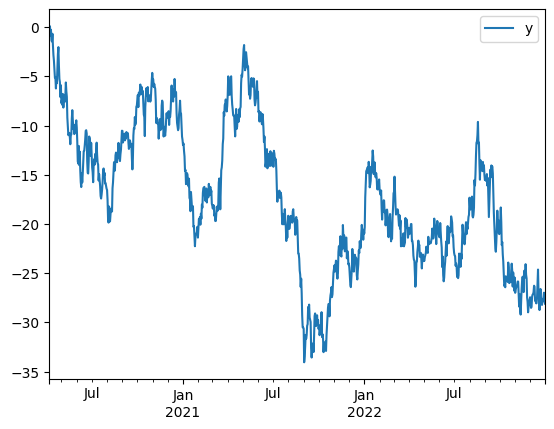

In [2]:
np.random.seed(41)
data = pd.Series(np.cumsum(np.random.normal(0, 1, size=1000)), 
                 index=pd.date_range(end='31/12/2022', periods=1000)).rename('y').to_frame()
data.plot()

## Section1: Difinir la liste des modeles a comparer

### Option 1 : List of Models from a LiquidityForecast Object List
Default choice if you have already estimated models and wish to compare them without re-estimating.
```python
import pickle
from forecast_combine.model_select import ForecastModelSelect

forecasters_paths_d = {'forecaster1': 'forecaster1.pkl',
                       'forecaster2': 'forecaster2.pkl',
                       'forecaster3': 'forecaster3.pkl'}
trained_forecasters_d= {}
for forecaster_name, file in forecasters_paths_d.items():
    with open(f, 'rb') as file:
        trained_forecasters_d[forecaster_name] = pickle.load(file)
    

model = ForecastModelSelect(
            data= data,
            depvar_str = 'y',                 
            exog_l=None,
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            trained_forecasters_d = ,
            freq = 'B',
            mode = 'best_horizon',
            score = 'RMSE', 
            )
```

### Option 2: List of Models from a dictionary
Default choice if you want to reestimate the models

In [3]:
# models necessary to define the forecasting models 
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS, 
    StatsForecastAutoTheta,
    StatsForecastAutoTBATS
)

In [4]:
ForecastingModels = {
    "Naive": NaiveForecaster(),
    "AutoARIMA": StatsForecastAutoARIMA(),
    "AutoETS": StatsForecastAutoETS(),
    "AutoTheta": StatsForecastAutoTheta(),
    "AutoTBATS": StatsForecastAutoTBATS(seasonal_periods=1),
}

In [5]:
from forecast_combine.model_select import ForecastModelSelect
model = ForecastModelSelect(
            data= data,
            depvar_str = 'y',                 
            exog_l=None,
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            forecasters_d = ForecastingModels,
            freq = 'B',
            mode = 'best_horizon',
            score = 'RMSE', 
            )

## Section 2: Evaluate the model OOS

In [6]:
summary_horizon, summary_results = model.evaluate()


Start Naive forecaster evalution....
Evaluation completed in: 0.03 minutes

Start AutoARIMA forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/arima.py:913: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/

Evaluation completed in: 0.206 minutes

Start AutoETS forecaster evalution....
Evaluation completed in: 0.326 minutes

Start AutoTheta forecaster evalution....
Evaluation completed in: 0.334 minutes

Start AutoTBATS forecaster evalution....


/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please use `season_length` instead.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/tbats.py:949: UserWarning: Data contains zero or negative values, disabling Box-Cox transformation.
  warnings.warn(
/home/ubuntu/Documents/Projects/forecast/.venv/lib/python3.9/site-packages/statsforecast/utils.py:356: FutureWarning: `seasonal_periods` has been deprecated, please u

Evaluation completed in: 0.283 minutes


In [7]:
display(summary_results.T.sort_values('Avg MAPE'))
display(summary_horizon.T)

,Number of Folds,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg RMSE,Avg MAE,Avg MAPE,Avg R2,Avg MedianAE
AutoETS,34,18.009544,0.376048,536,701,2022-04-25,2022-12-12,2.019726,1.733429,0.087,-1.767929,1.674376
Naive,34,0.002106,0.025725,536,701,2022-04-25,2022-12-12,2.021177,1.736727,0.087156,-1.771201,1.677154
AutoARIMA,34,9.970235,1.105146,536,701,2022-04-25,2022-12-12,2.021177,1.736727,0.087156,-1.771201,1.677154
AutoTheta,34,18.800914,0.207378,536,701,2022-04-25,2022-12-12,2.02219,1.738318,0.087363,-1.836274,1.670662
AutoTBATS,34,14.517969,0.00455,536,701,2022-04-25,2022-12-12,2.031738,1.744463,0.087504,-1.803045,1.677432


horizon                   1         2         3         4         5   \
Naive     RMSE      1.061377  1.289178  1.630512  2.254094  2.576261   
          MAE       0.907418  1.013794  1.290828  1.699662  1.739813   
          MAPE      0.043504  0.048121  0.064628  0.085317  0.089614   
          R2        0.933879  0.907969  0.859301  0.732285  0.641995   
          MedianAE  0.797864  0.933536  1.002693  1.366604  1.058810   
AutoARIMA RMSE      1.061377  1.289178  1.630512  2.254094  2.576261   
          MAE       0.907418  1.013794  1.290828  1.699662  1.739813   
          MAPE      0.043504  0.048121  0.064628  0.085317  0.089614   
          R2        0.933879  0.907969  0.859301  0.732285  0.641995   
          MedianAE  0.797864  0.933536  1.002693  1.366604  1.058810   
AutoETS   RMSE      1.048703  1.283647  1.628556  2.247015  2.569364   
          MAE       0.894163  1.011219  1.288419  1.692707  1.737660   
          MAPE      0.042808  0.048041  0.064574  0.084885  0.089494   
          R2        0.935449  0.908757  0.859639  0.733964  0.643909   
          MedianAE  0.741794  0.921027  0.983135  1.406859  1.066758   
AutoTheta RMSE      1.049548  1.281889  1.620781  2.239241  2.568009   
          MAE       0.897092  1.011542  1.282696  1.688081  1.747038   
          MAPE      0.042944  0.048107  0.064431  0.084725  0.090068   
          R2        0.935345  0.909007  0.860976  0.735802  0.644285   
          MedianAE  0.740199  0.894488  1.011754  1.415226  1.151618   
AutoTBATS RMSE      1.045996  1.286561  1.633222  2.263869  2.574556   
          MAE       0.886420  1.009424  1.292777  1.716613  1.737230   
          MAPE      0.042501  0.047935  0.064714  0.085767  0.089621   
          R2        0.935782  0.908343  0.858833  0.729958  0.642469   
          MedianAE  0.706985  0.928697  0.995824  1.373619  0.981105   

horizon                   6         7         8         9         10  
Naive     RMSE      2.738026  2.884521  3.106418  3.031601  2.994344  
          MAE       2.020258  2.025647  2.087423  2.334944  2.247488  
          MAPE      0.101173  0.102446  0.111722  0.113121  0.111918  
          R2        0.591475  0.555429  0.503621  0.541026  0.538249  
          MedianAE  1.588652  1.266318  1.695619  1.800259  1.876376  
AutoARIMA RMSE      2.738026  2.884521  3.106418  3.031601  2.994344  
          MAE       2.020258  2.025647  2.087423  2.334944  2.247488  
          MAPE      0.101173  0.102446  0.111722  0.113121  0.111918  
          R2        0.591475  0.555429  0.503621  0.541026  0.538249  
          MedianAE  1.588652  1.266318  1.695619  1.800259  1.876376  
AutoETS   RMSE      2.729837  2.874355  3.102975  3.028332  2.991519  
          MAE       2.015818  2.018497  2.093435  2.338340  2.244034  
          MAPE      0.100891  0.102089  0.112064  0.113355  0.111798  
          R2        0.593915  0.558557  0.504721  0.542016  0.539120  
          MedianAE  1.577479  1.287694  1.670992  1.818097  1.867328  
AutoTheta RMSE      2.729978  2.874140  3.089624  3.016118  2.988911  
          MAE       2.012824  2.034200  2.084981  2.343175  2.281549  
          MAPE      0.100822  0.102926  0.111856  0.113860  0.113889  
          R2        0.593873  0.558623  0.508973  0.545703  0.539923  
          MedianAE  1.560120  1.354559  1.544505  1.834696  1.750665  
AutoTBATS RMSE      2.726024  2.878797  3.115569  3.063530  3.009160  
          MAE       2.015204  1.995114  2.135794  2.380621  2.275436  
          MAPE      0.100784  0.101308  0.113943  0.115077  0.113392  
          R2        0.595049  0.557192  0.500692  0.531308  0.533668  
          MedianAE  1.562263  1.129967  1.778593  1.805298  2.162812

## Section 3: Select the best model

In [8]:
rank, score = model.select_best(score = 'MAPE')
display(rank)
display(score)

horizon,1,2,3,4,5,6,7,8,9,10
Best_1,AutoTBATS,AutoTBATS,AutoTheta,AutoTheta,AutoETS,AutoTBATS,AutoTBATS,Naive,Naive,AutoETS
Best_2,AutoETS,AutoETS,AutoETS,AutoETS,Naive,AutoTheta,AutoETS,AutoARIMA,AutoARIMA,Naive
Best_3,AutoTheta,AutoTheta,Naive,Naive,AutoARIMA,AutoETS,Naive,AutoTheta,AutoETS,AutoARIMA
Best_4,Naive,Naive,AutoARIMA,AutoARIMA,AutoTBATS,Naive,AutoARIMA,AutoETS,AutoTheta,AutoTBATS
Best_5,AutoARIMA,AutoARIMA,AutoTBATS,AutoTBATS,AutoTheta,AutoARIMA,AutoTheta,AutoTBATS,AutoTBATS,AutoTheta


,Naive,AutoARIMA,AutoETS,AutoTheta,AutoTBATS,Best Model (over all),Best Model (per horizon),Best 2 Models (over all),Best 2 Models (per horizon),Model Avg (all models)
horizon,,,,,,,,,,
1,0.043504,0.043504,0.042808,0.042944,0.042501,0.042808,0.042501,0.043156,0.042654,0.043052
2,0.048121,0.048121,0.048041,0.048107,0.047935,0.048041,0.047935,0.048081,0.047988,0.048065
3,0.064628,0.064628,0.064574,0.064431,0.064714,0.064574,0.064431,0.064601,0.064502,0.064595
4,0.085317,0.085317,0.084885,0.084725,0.085767,0.084885,0.084725,0.085101,0.084805,0.085202
5,0.089614,0.089614,0.089494,0.090068,0.089621,0.089494,0.089494,0.089554,0.089554,0.089682
6,0.101173,0.101173,0.100891,0.100822,0.100784,0.100891,0.100784,0.101032,0.100803,0.100968
7,0.102446,0.102446,0.102089,0.102926,0.101308,0.102089,0.101308,0.102267,0.101698,0.102243
8,0.111722,0.111722,0.112064,0.111856,0.113943,0.112064,0.111722,0.111893,0.111722,0.112261
9,0.113121,0.113121,0.113355,0.113860,0.115077,0.113355,0.113121,0.113238,0.113121,0.113707


<Axes: title={'center': 'Out of Sample Performance'}, xlabel='horizon', ylabel='MAPE'>

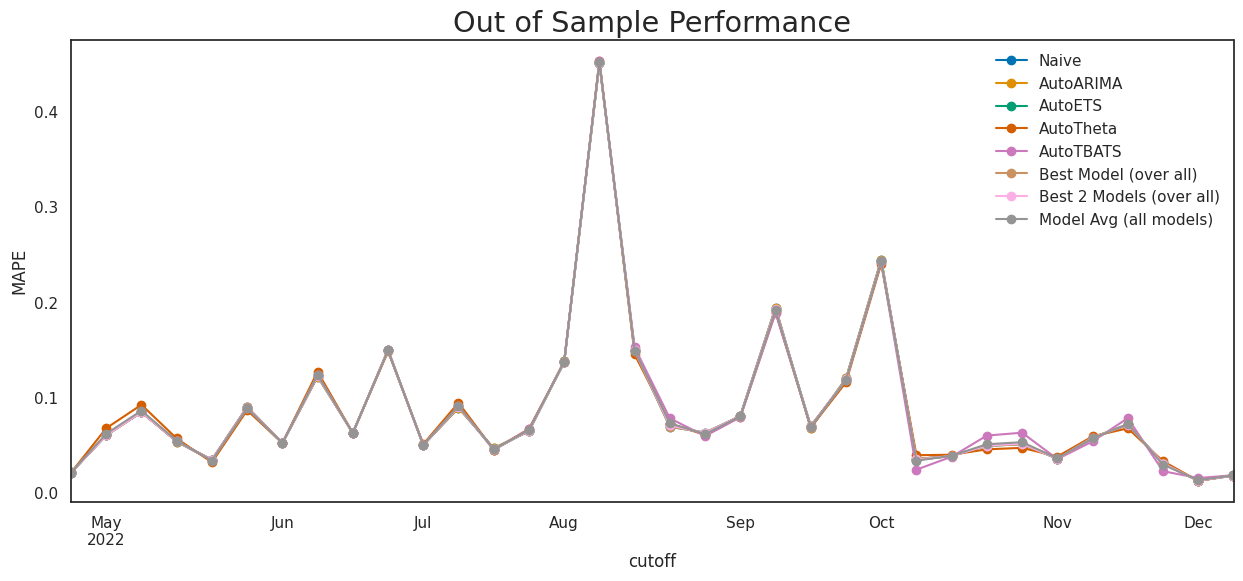

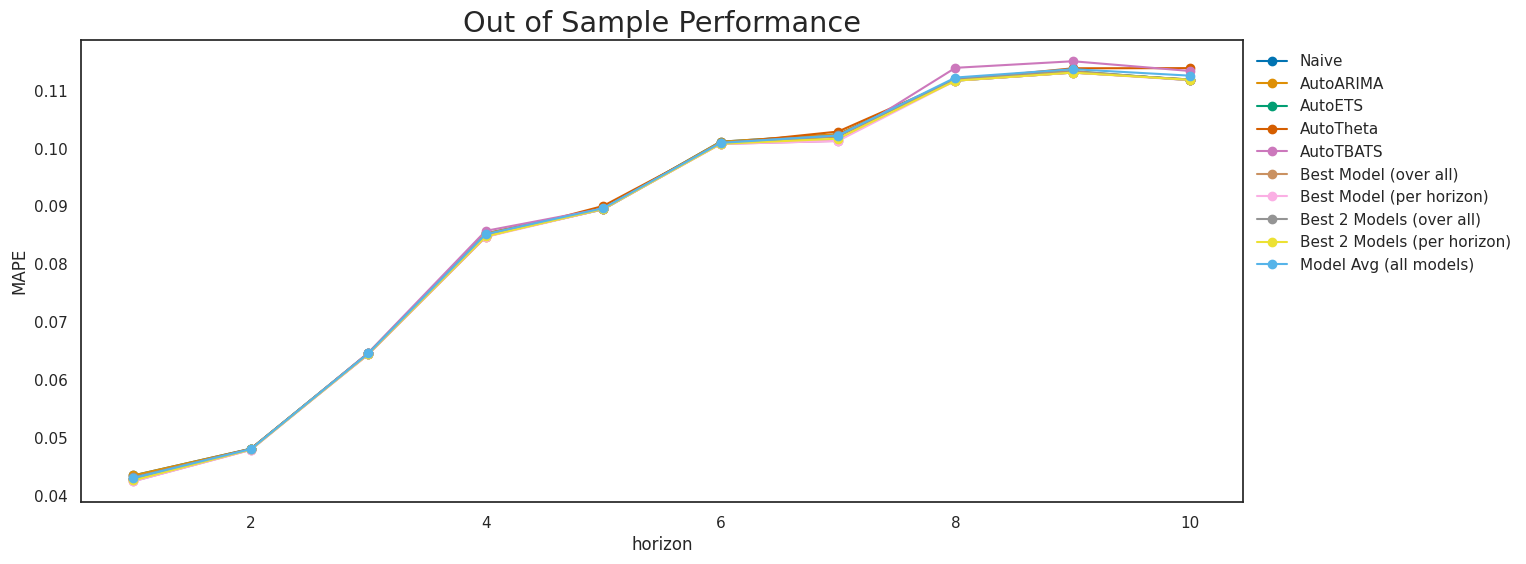

In [9]:
model.plot_model_compare(score ='MAPE', view = 'cutoff')
model.plot_model_compare(score ='MAPE', view = 'horizon')

## Section 4 : Generate Predictions
The prediction aggregate the single models predictions is several ways:
* 'best': The prediction is based on the best model.
* 'best_horizon': The prediction is based on the best model for each horizon.
* 'average': The average of the prediction of all models.
* 'inverse_score': The weighted average prediction, where weights are inversely proportional to the model performance score.
* 'nbest_average': Average of the n best models. The n is given by the parameter nbest.
* 'nbest_average_horizon': Average of the n best models for each horizon. The n is given by the parameter nbest.

(<Figure size 1500x600 with 1 Axes>, <Axes: title={'center': 'Prediction'}>)

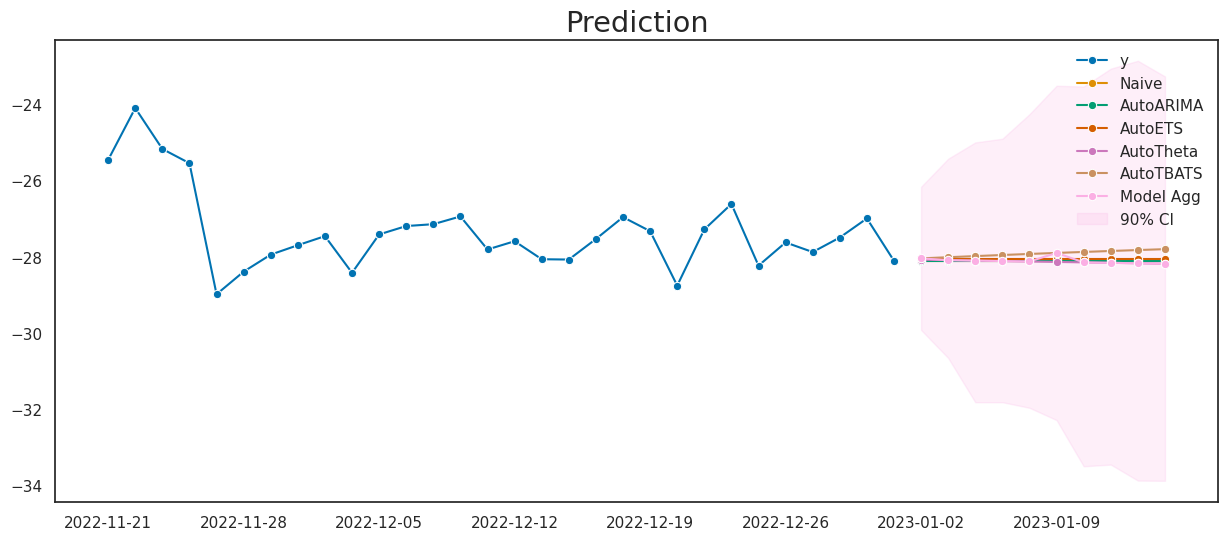

In [10]:
y_pred, y_pred_ints, preds, pred_ints = model.predict(mode='best_horizon', ret_underlying=True)
model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints)  

## Section 5: Update data and regenerate the model

In [11]:
# create a dataframe with the new data
newdata = pd.concat([data, 
                     pd.DataFrame(index=[y_pred.index[0]], columns =data.columns)
                    ])
newdata.loc[y_pred.index[0], 'BMC'] = y_pred.iloc[0]
newdata = newdata.ffill()

<Axes: title={'center': 'Prediction'}>

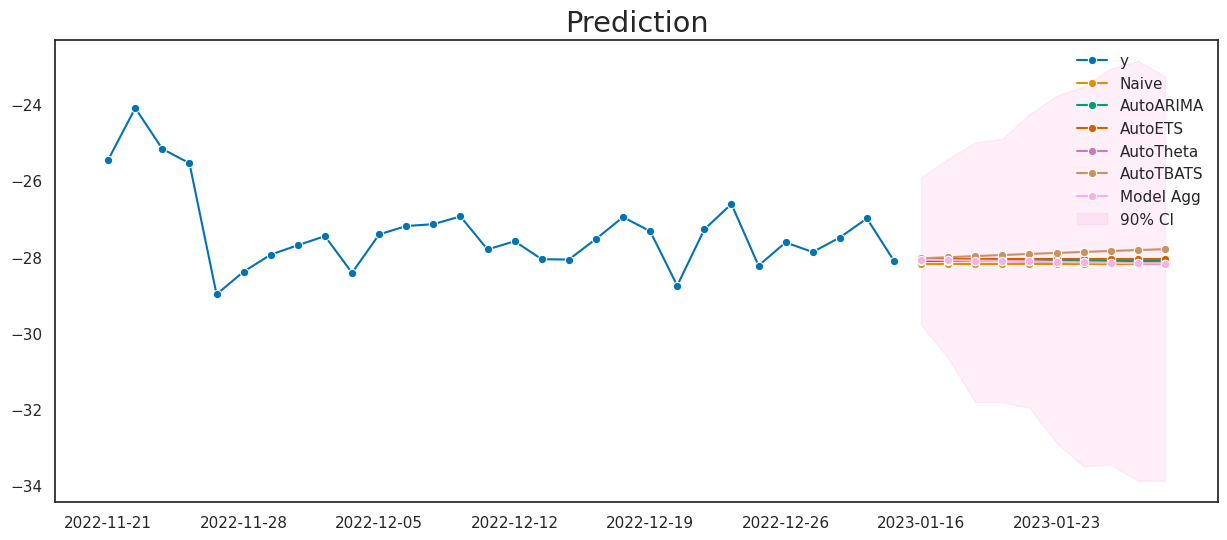

In [12]:
new_y = pd.concat([data.squeeze(),y_pred], axis=0)
y_pred, y_pred_ints, preds, pred_ints = model.update(new_y=new_y, mode='best', 
                                                     ret_underlying=True)
f, ax = model.plot_prediction(y_pred = y_pred,
                     models_preds = preds,
                     y_pred_interval = y_pred_ints)    
ax

In [13]:
model.get_pred_errors()

,cutoff,horizon,error
0,2022-04-25,1,-0.687173
1,2022-05-02,1,0.367276
2,2022-05-09,1,1.635482
3,2022-05-16,1,0.267934
4,2022-05-23,1,0.420324
...,...,...,...
335,2022-11-14,10,-1.560651
336,2022-11-21,10,-1.739057
337,2022-11-28,10,0.927599
338,2022-12-05,10,0.230808
